In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
x_train_a = pd.read_csv('cleaned_data/A/x_train_a.csv')
x_train_b = pd.read_csv('cleaned_data/B/x_train_b.csv')
x_train_c = pd.read_csv('cleaned_data/C/x_train_c.csv')

x_test_a = pd.read_csv('cleaned_data/A/x_test_a.csv')
x_test_b = pd.read_csv('cleaned_data/B/x_test_b.csv')
x_test_c = pd.read_csv('cleaned_data/C/x_test_c.csv')

train_a = pd.read_csv('cleaned_data/A/train_a.csv')
train_b = pd.read_csv('cleaned_data/B/train_b.csv')
train_c = pd.read_csv('cleaned_data/C/train_c.csv')

In [3]:
train_a['time'] = pd.to_datetime(train_a['time'])
train_b['time'] = pd.to_datetime(train_b['time'])
train_c['time'] = pd.to_datetime(train_c['time'])

In [4]:
x_test_a = x_test_a.drop(columns = ['date_forecast'])
x_test_b = x_test_b.drop(columns = ['date_forecast'])
x_test_c = x_test_c.drop(columns = ['date_forecast'])


In [5]:
#Remove rows in X_train that has timestamp that does not exist in train_loc, and visa_verca
#e.g missing solar power measurements from 2022-10-21 01:00 - 2022-10-28 21:00
def align_X_y(x_train,y_train, x_date_column='date_forecast', y_date_column='time'):
    """
    Aligns two dataframes based on the 'date_forecast' column of X and the 'time' column of y,
    ensuring that only rows with matching time values are retained.

    Parameters:
    - X (pd.DataFrame): The first dataframe with time in the 'date_forecast'
    - y (pd.DataFrame): The second dataframe with time in the 'time' column.

    Returns:
    - tuple: A tuple containing the aligned dataframes.
    """
    # Convert date columns to datetime format for easier comparison
    x_train[x_date_column] = pd.to_datetime(x_train[x_date_column])
    y_train[y_date_column] = pd.to_datetime(y_train[y_date_column])
    
    # Find common dates
    common_dates = x_train[x_date_column][x_train[x_date_column].isin(y_train[y_date_column])]
    
    # Filter both datasets based on common dates
    x_train_synced = x_train[x_train[x_date_column].isin(common_dates)]
    y_train_synced = y_train[y_train[y_date_column].isin(common_dates)]
    
    return x_train_synced, y_train_synced


# Analysis of Target variable  - Looking at PV_measurement
1. Handle constant measurments over longer periods of time. Likely caused by sensor malfunction, data logging issues, or other external factors.
    - Handeled by removing all constant values lasting more than 24 hours 
2. Add cyclical features 
2. Handle longer periods of missing data:
    - Remove (currently tested)
    - Interpolate 
    - Copy from previous year
    - Copy solar production at missing time from another location

### 1. Handle constant PV measurements 

In [6]:
# Time-Series plot of PV_measurement 

def solar_prod_plot(y_train, resolution='year', chunks=5):
    df = y_train.copy()
    
    # Determine the plotting resolution based on the 'resolution' argument
    # Chunks = number of year/months/days in each plot
    if resolution == 'year':
        unique_values = df['time'].dt.year.unique()
        label = 'Year'
    elif resolution == 'month':
        df['year_month'] = df['time'].dt.to_period('M')
        unique_values = df['year_month'].unique()
        label = 'Month'
    elif resolution == 'week':
        df['year_week'] = df['time'].dt.to_period('W')
        unique_values = df['year_week'].unique()
        label = 'Week'
    elif resolution == 'day':
        df['date'] = df['time'].dt.date
        unique_values = df['date'].unique()
        label = 'Day'
    else:
        raise ValueError("Invalid resolution. Choose from 'year', 'month', 'week', or 'day'.")
    
    # Loop over the unique values in chunks
    for i in range(0, len(unique_values), chunks):
        subset_values = unique_values[i:i+chunks]
        
        if resolution == 'year':
            subset_df = df[df['time'].dt.year.isin(subset_values)]
        elif resolution == 'month':
            subset_df = df[df['year_month'].isin(subset_values)]
        elif resolution == 'week':
            subset_df = df[df['year_week'].isin(subset_values)]
        elif resolution == 'day':
            subset_df = df[df['date'].isin(subset_values)]
        
        plt.figure(figsize=(15, 6))
        plt.plot(subset_df['time'], subset_df['pv_measurement'])

        title = f"Solar Power Production for {label}: {subset_values[0]}"
        if len(subset_values) > 1:
            title += f" to {subset_values[-1]}"

        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("PV Measurement")
        plt.show()

def remove_constant_intervals(y_train, low_thresh, upp_thresh):
    """
    Identify and remove intervals of constant PV readings that exceed a specified duration. 
    Constant readings may indicate sensor malfunctions or data logging issues.
    
    Parameters:
    ----------
    y_train : pd.DataFrame
        Dataframe containing the time-series data of solar power production.
    threshold : int
        The minimum duration required for an interval to be considered for removal.
        
    Returns:
    -------
    pd.DataFrame
        The input dataframe with intervals of constant readings (exceeding the duration threshold) removed.
    """
    df = y_train.copy()
    
    # Calculate the difference in production values
    df['diff'] = df['pv_measurement'].diff()

    # Identify where the difference is zero
    df['zero_diff'] = df['diff'].abs() < 1e-5

    # Identify groups of consecutive zero differences
    df['group'] = (df['zero_diff'] != df['zero_diff'].shift()).cumsum()

    # Filter out only the groups with consecutive zero differences
    constant_intervals = df[df['zero_diff']].groupby('group').agg(start=('time', 'min'), 
                                                                  end=('time', 'max'),
                                                                  duration=('time', 'size'))
    
    # Filter intervals based on the threshold
    interval_df_thresh = constant_intervals[(constant_intervals['duration'] > low_thresh) & (constant_intervals['duration'] <upp_thresh)]
    
    # Remove rows from the main dataframe that fall within these intervals
    for _, row in interval_df_thresh.iterrows():
        start_time, end_time = row['start'], row['end']
        df = df[(df['time'] < start_time) | (df['time'] > end_time)]
    
    # Drop the added columns used for calculations
    df.drop(columns=['diff', 'zero_diff', 'group'], inplace=True)
    
    return df, constant_intervals


def get_time_interval(df, start_time = '2020-08-01 00:00:00', end_time = '2021-01-01 00:00:00'):
    # Filter rows based on the time period
    filtered_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    return filtered_df

In [7]:
#Removed all constant values with duration > 24 hours

train_a, const_interval_a = remove_constant_intervals(train_a,24,10**6)

#update X_train_a by removing coresponding rows that have been filtered here
x_train_a, train_a = align_X_y(x_train_a, train_a)

In [8]:
rows_removed_a = np.sum(const_interval_a[const_interval_a['duration']>24]['duration'])
print(f'total number of rows removed {rows_removed_a}')
const_interval_a[const_interval_a['duration']>24]

total number of rows removed 42


,start,end,duration
group,,,
434,2020-01-04 15:00:00,2020-01-06 08:00:00,42


In [9]:
#Remove rows in groups of constant values, where duration of constant measurements is > 1 day (24 hours)
train_b, const_interval_b = remove_constant_intervals(train_b,24,10**6)

#update X_train_a by removing coresponding rows that have been filtered here
x_train_b, train_b = align_X_y(x_train_b, train_b)

In [10]:
rows_removed = np.sum(const_interval_b[const_interval_b['duration']>24]['duration'])
print(f'total number of rows removed {rows_removed}')
const_interval_b[const_interval_b['duration']>24]

total number of rows removed 6865


,start,end,duration
group,,,
32,2019-01-14 15:00:00,2019-01-18 11:00:00,93
36,2019-01-19 13:00:00,2019-01-26 08:00:00,164
40,2019-01-27 11:00:00,2019-01-28 13:00:00,27
74,2019-02-10 16:00:00,2019-02-13 07:00:00,64
160,2019-03-23 18:00:00,2019-03-26 06:00:00,61
302,2019-05-31 08:00:00,2019-06-03 12:00:00,77
606,2019-10-28 14:00:00,2019-10-30 22:00:00,57
674,2019-12-01 13:00:00,2019-12-04 08:00:00,68
682,2019-12-07 14:00:00,2019-12-11 08:00:00,91


In [11]:
#Remove rows in groups of constant values, where duration of constant measurements is > 1 day (24 hours)
train_c, const_interval_c = remove_constant_intervals(train_c,24,10**6)

#update X_train_a by removing coresponding rows that have been filtered here
x_train_c, train_c = align_X_y(x_train_c, train_c)

In [12]:
rows_removed = np.sum(const_interval_c[const_interval_c['duration']>24]['duration'])
print(f'total number of rows removed {rows_removed}')
const_interval_c[const_interval_c['duration']>24]

total number of rows removed 4926


,start,end,duration
group,,,
2,2019-09-04 10:00:00,2019-09-05 12:00:00,27
180,2019-11-11 12:00:00,2019-11-13 08:00:00,45
230,2019-11-28 15:00:00,2019-12-05 09:00:00,163
240,2019-12-07 14:00:00,2019-12-13 09:00:00,140
256,2019-12-16 14:00:00,2019-12-21 09:00:00,116
276,2019-12-25 13:00:00,2019-12-30 09:00:00,117
290,2020-01-02 14:00:00,2020-01-07 09:00:00,116
340,2020-01-23 15:00:00,2020-01-26 08:00:00,66
376,2020-02-05 14:00:00,2020-02-10 07:00:00,114


### Merge x_train and y_train

In [13]:
merged_a = pd.merge(x_train_a, train_a, left_on='date_forecast', right_on='time', how='inner')
merged_b = pd.merge(x_train_b, train_b, left_on='date_forecast', right_on='time', how='inner')
merged_c = pd.merge(x_train_c, train_c, left_on='date_forecast', right_on='time', how='inner')

### Handle NaN values

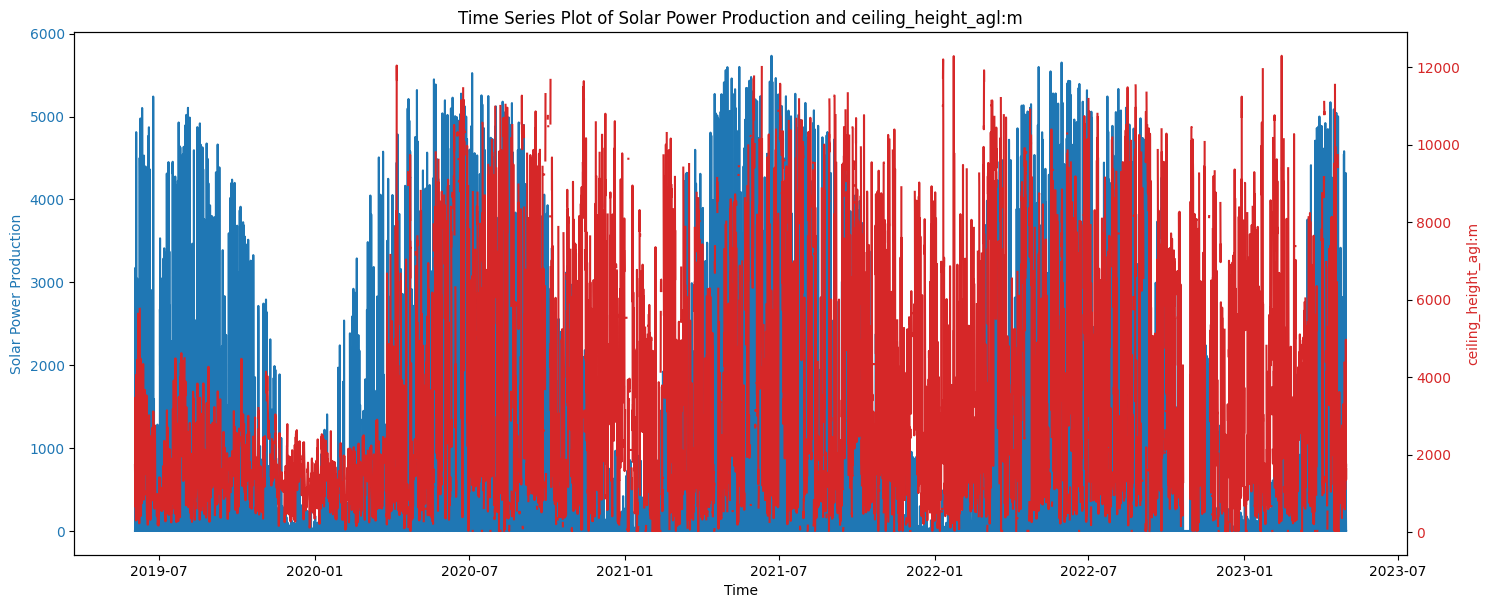

In [14]:
#Here we are plotting on the modified dataset
def time_series_plot(feature,merged_data):
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Solar Power Production', color='tab:blue')
    ax1.plot(merged_data['time'], merged_data['pv_measurement'], color='tab:blue', label='Solar Power Production')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel(feature, color='tab:red')  
    ax2.plot(merged_data['date_forecast'], merged_data[feature], color='tab:red', label=feature)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'Time Series Plot of Solar Power Production and {feature}')
    plt.show()

time_series_plot('ceiling_height_agl:m', merged_a)

In [15]:
merged_a.isnull().sum().sort_values(ascending = False)


snow_density:kgm3                 32903
ceiling_height_agl:m               6151
cloud_base_agl:m                   2387
sfc_pressure:hPa                     24
wind_speed_u_10m:ms                  24
precip_type_5min:idx                 24
pressure_100m:hPa                    24
absolute_humidity_2m:gm3             24
prob_rime:p                          24
wind_speed_10m:ms                    24
relative_humidity_1000hPa:p          24
pressure_50m:hPa                     24
is_in_shadow:idx                     24
snow_depth:cm                        24
snow_drift:idx                       24
visibility:m                         24
total_cloud_cover:p                  24
sun_azimuth:d                        24
sun_elevation:d                      24
msl_pressure:hPa                     24
wind_speed_v_10m:ms                  24
is_day:idx                           24
t_1000hPa:K                          24
air_density_2m:kgm3                  24
clear_sky_rad:W                      24


In [16]:
merged_a['ceiling_height_agl:m'] = merged_a['ceiling_height_agl:m'].fillna(value = 0)
merged_b['ceiling_height_agl:m'] = merged_b['ceiling_height_agl:m'].fillna(value = 0)
merged_c['ceiling_height_agl:m'] = merged_c['ceiling_height_agl:m'].fillna(value = 0)

In [17]:
merged_a.isnull().sum()

date_forecast                         0
absolute_humidity_2m:gm3             24
air_density_2m:kgm3                  24
ceiling_height_agl:m                  0
clear_sky_energy_1h:J                 0
clear_sky_rad:W                      24
cloud_base_agl:m                   2387
dew_or_rime:idx                      24
dew_point_2m:K                       24
diffuse_rad:W                        24
diffuse_rad_1h:J                      0
direct_rad:W                         24
direct_rad_1h:J                       0
effective_cloud_cover:p              24
elevation:m                          24
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                           24
is_in_shadow:idx                     24
msl_pressure:hPa                     24
precip_5min:mm                        0
precip_type_5min:idx                 24


### Add Cyclical Features

In [ ]:
# Creating cyclical features for hour of the day
def cyclic_hourly(x):
    train_data = x.copy()
    train_data['hour_sin'] = np.sin(2 * np.pi * train_data['hour'] / 24)
    train_data['hour_cos'] = np.cos(2 * np.pi * train_data['hour'] / 24)
    return train_data


# Creating cyclical features for month of the year
def cyclic_monthly(x):
    train_data = x.copy()
    train_data['month_sin'] = np.sin(2 * np.pi * train_data['month'] / 12)
    train_data['month_cos'] = np.cos(2 * np.pi * train_data['month'] / 12)
    return train_data

"""
x_train_a = cyclic_hourly(x_train_a)
x_train_a = cyclic_monthly(x_train_a)

x_test_a = cyclic_hourly(x_test_a)
x_test_a = cyclic_monthly(x_test_a)

x_train_b = cyclic_hourly(x_train_b)
x_train_b = cyclic_monthly(x_train_b)

x_test_b = cyclic_hourly(x_test_b)
x_test_b = cyclic_monthly(x_test_b)

x_train_c = cyclic_hourly(x_train_c)
x_train_c = cyclic_monthly(x_train_c)

x_test_c = cyclic_hourly(x_test_c)
x_test_c = cyclic_monthly(x_test_c)
"""

### Remove outliers during night

In [ ]:
def plot_hourly_avg(y_train):
    # Grouping by hour and calculating the average PV measurement for each hour
    train_data = y_train.copy()
    train_data['hour'] = y_train['time'].dt.hour
    hourly_avg = train_data.groupby('hour')['pv_measurement'].mean()

    # Plotting the average PV production for each hour
    plt.figure(figsize=(12, 6))
    hourly_avg.plot(kind='bar', color='skyblue')
    plt.title('Average PV Production by Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average PV Production')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_dist_hour(y_train, hour):
    train_data = y_train.copy()
    train_data['hour'] = y_train['time'].dt.hour
    
    # Filtering the data for the given hour
    hour_data = train_data[train_data['hour'] == hour]
    
    # Plotting the distribution of PV measurements for 1 am
    plt.figure(figsize=(12, 6))
    plt.hist(hour_data['pv_measurement'], bins=50, color='teal', alpha=0.7)
    plt.title(f'Distribution of PV Measurements at {hour}')
    plt.xlabel('PV Measurement')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print(hour_data['pv_measurement'].value_counts())
#train_c[(train_c['time'].dt.hour == 2) &(train_c['pv_measurement'] == 9.8)]

def get_nighttime_stats(y_train,night_start,night_end):
    train_data = y_train.copy()
    train_data['hour'] = y_train['time'].dt.hour

    # Filtering the data for nighttime hours (8 pm to 4 am)
    nighttime_data = train_data[(train_data['hour'] >= night_start) | (train_data['hour'] <= night_end)]

    # Descriptive statistics for nighttime PV measurements
    nighttime_stats = nighttime_data['pv_measurement'].describe()

    # Plotting the distribution of nighttime PV measurements
    plt.figure(figsize=(12, 6))
    plt.hist(nighttime_data['pv_measurement'], bins=50, color='purple', alpha=0.7)
    plt.axvline(nighttime_stats['75%'], color='red', linestyle='dashed', label='75th Percentile')
    plt.axvline(nighttime_stats['max'], color='green', linestyle='dashed', label='Max Value')
    plt.title('Distribution of Nighttime PV Measurements')
    plt.xlabel('PV Measurement')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(nighttime_stats)
    
def set_nighttime_to_zero(y_train, night_start,night_end, thresh):
    df = y_train.copy()
    df['hour'] = y_train['time'].dt.hour
    mask = (df['hour'] >= 23) | (df['hour'] <= 3) & (df['pv_measurement'] > thresh)
    df.loc[mask, 'pv_measurement'] = 0
    df = df.drop(columns = ['hour'])
    return df

#train_a[(train_a['time'].dt.hour == 2) &(train_a['pv_measurement'] >0)]
#train_a = set_nighttime_to_zero(train_a,23,3,0)
#train_b = set_nighttime_to_zero(train_b,23,3,0)
#train_c = set_nighttime_to_zero(train_c,23,3,0)
#train_a[(train_a['time'].dt.hour == 2) &(train_a['pv_measurement'] >0)]

### Remove rows with high rad values and zero PV 

In [ ]:
def remove_rad_null(merged_df):
    merged_data = merged_df.copy()
    merged_data['clear_sky_rad:W'].fillna(0, inplace=True)
    merged_data['clear_sky_rad:W'].fillna(0, inplace=True)
    merged_data['direct_rad:W'].fillna(0, inplace=True)
    merged_data['direct_rad_1h:J'].fillna(0, inplace=True)
    return merged_data
"""
m_a = remove_rad_null(merged_a)
m_b = remove_rad_null(merged_b)
m_c = remove_rad_null(merged_c)
"""

def get_percentiles_df(merged_df):
    merged_data = merged_df.copy()
    merged_data['clear_sky_rad:W'].fillna(0, inplace=True)
    merged_data['clear_sky_rad:W'].fillna(0, inplace=True)
    merged_data['direct_rad:W'].fillna(0, inplace=True)
    merged_data['direct_rad_1h:J'].fillna(0, inplace=True)

    # Calculate and display percentiles
    percentiles = [50,60,70,80,85,90,95]
    percentile_values_direct_rad= np.percentile(merged_data['direct_rad:W'], percentiles)
    percentile_values_direct_rad_1h = np.percentile(merged_data['direct_rad_1h:J'], percentiles)
    percentile_values_clear_sky_rad = np.percentile(merged_data['clear_sky_rad:W'], percentiles)
    percentile_values_clear_sky_energy = np.percentile(merged_data['clear_sky_energy_1h:J'], percentiles)
    percentile_values_df = pd.DataFrame({
        'Percentile': percentiles,
        'direct_rad:W':percentile_values_direct_rad,
        'direct_rad_1h:J': percentile_values_direct_rad_1h,
        'clear_sky_rad:W': percentile_values_clear_sky_rad,
        'clear_sky_energy_1h:J': percentile_values_clear_sky_energy
        })
    
    return percentile_values_df

def get_anomals(merged_data,feature,percentile): 
    #identify the rows where the "direct_rad:W" column in x_train_a is high
    #but the PV measurement in train_a is zero -> Indicates wrong
    
    percentile_df = get_percentiles_df(merged_data)
    
    # Define a threshold for high solar radiation
    threshold = percentile_df[percentile_df['Percentile']==percentile][feature].values[0],

    # Find rows where 'direct_rad:W' is high but PV measurement is zero
    anomalous_rows = merged_data[(merged_data[feature] > threshold) & (merged_data['pv_measurement'] == 0)]
    
    
    # Display the anomalous rows
    return anomalous_rows
"""
merged_a1 = merged_a.copy().drop(get_anomals(merged_a,'clear_sky_rad:W',90).index)
merged_b1 = merged_b.copy().drop(get_anomals(merged_b,'direct_rad:W',90).index)
merged_c1 = merged_c.copy().drop(get_anomals(merged_c,'direct_rad_1h:J',90).index)
"""

In [ ]:
def split_dataset(train_data, estimated_column='estimated',val_size = 0.1,val = False):
    """
    Splits the dataset into a training set and a validation set.
    The validation set contains the last half of the rows where observed = 0,
    and the training set contains the rest.

    :param train_data: The original training dataset as a pandas DataFrame.
    :param observed_column: The name of the column that indicates if the row is observed.
    :return: A tuple (training_set, validation_set)
    """
    
    if val: 
        estimated_one = train_data[train_data[estimated_column] == 1]

        #Split the filtered dataset into two
        half_index = len(estimated_one) // 2
        validation_set = estimated_one[half_index:]

        # Combine the first half of observed_zero with the rest of the data where observed != 0
        training_set = pd.concat([train_data[train_data[estimated_column] == 0], estimated_one[:half_index]])
    else:
        split_index = int(train_data.shape[0] * (1-val_size))

        # Split the data
        training_set = train_data.iloc[:split_index]
        validation_set = train_data.iloc[split_index:]

    # Filter rows where observed = 0
   
    return training_set, validation_set


### Add direct_rad + sun_elevation feature

In [ ]:
def add_rad_x_sun(merged_data):
    df = merged_data.copy()
    df['rad_x_sun_elevation'] = df['direct_rad:W']*df['sun_elevation:d']
    return df

mod_a = add_rad_x_sun(merged_a)
mod_b = add_rad_x_sun(merged_b)
mod_c = add_rad_x_sun(merged_c)

In [ ]:
time_series_plot('rad_x_sun_elevation',df.reset_index())

## Build Catboost model 

In [18]:
def split_dataset(train_data, val_size=0.1, val = False, estimated_column = 'estimated'):
    if val: 
        estimated_one = train_data[train_data[estimated_column] == 1]

        #Split the filtered dataset into two
        half_index = len(estimated_one) // 2
        validation_set = estimated_one[half_index:]

        # Combine the first half of observed_zero with the rest of the data where observed != 0
        training_set = pd.concat([train_data[train_data[estimated_column] == 0], estimated_one[:half_index]])
    else:
        split_index = int(train_data.shape[0] * (1 - val_size))
        training_set = train_data.iloc[:split_index]
        validation_set = train_data.iloc[split_index:]
    return training_set, validation_set

def build_catboost(merged_df, val_size=0.1, randomized=False):
    merged_df = merged_df.drop(columns=['date_forecast','time'])
    if randomized:
        X = merged_df.drop(columns=['pv_measurement'])
        y = merged_df['pv_measurement']
        X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)
    else:
        training_set, validation_set = split_dataset(merged_df, val_size, True)
        X_train = training_set.drop(columns=['pv_measurement'])
        y_train = training_set['pv_measurement']
        X_validation = validation_set.drop(columns=['pv_measurement'])
        y_validation = validation_set['pv_measurement']
    
    catboost_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=42,
        verbose=200
    )
    
    catboost_model.fit(X_train, y_train, eval_set=(X_validation, y_validation), use_best_model=True)
    return catboost_model


In [19]:
model_a = build_catboost(merged_a,0.125, True)

0:	learn: 600.2686128	test: 598.9900368	best: 598.9900368 (0)	total: 65ms	remaining: 1m 4s
200:	learn: 188.4720361	test: 185.6747035	best: 185.6747035 (200)	total: 2.08s	remaining: 8.27s
400:	learn: 172.5822489	test: 176.8793612	best: 176.8793612 (400)	total: 4.08s	remaining: 6.1s
600:	learn: 164.3936856	test: 173.6439457	best: 173.6439457 (600)	total: 6.03s	remaining: 4s
800:	learn: 158.7816761	test: 171.7490840	best: 171.7481648 (797)	total: 7.88s	remaining: 1.96s
999:	learn: 154.9363356	test: 170.5598114	best: 170.5459008 (998)	total: 9.8s	remaining: 0us

bestTest = 170.5459008
bestIteration = 998

Shrink model to first 999 iterations.


In [20]:
model_b = build_catboost(merged_b,0.125, True)

0:	learn: 98.2556381	test: 97.5971320	best: 97.5971320 (0)	total: 13.3ms	remaining: 13.3s
200:	learn: 25.0064808	test: 27.1964993	best: 27.1964993 (200)	total: 1.78s	remaining: 7.08s
400:	learn: 22.8107316	test: 26.2712758	best: 26.2712758 (400)	total: 3.6s	remaining: 5.38s
600:	learn: 21.8804495	test: 25.9804565	best: 25.9804565 (600)	total: 5.37s	remaining: 3.57s
800:	learn: 21.0188257	test: 25.6895345	best: 25.6893668 (799)	total: 7.54s	remaining: 1.87s
999:	learn: 20.1347880	test: 25.5745882	best: 25.5745882 (999)	total: 9.36s	remaining: 0us

bestTest = 25.57458821
bestIteration = 999



In [21]:
model_c = build_catboost(merged_c,0.125, True)

0:	learn: 89.8955069	test: 89.5916507	best: 89.5916507 (0)	total: 11.3ms	remaining: 11.3s
200:	learn: 21.4034839	test: 23.7270546	best: 23.7270546 (200)	total: 1.72s	remaining: 6.85s
400:	learn: 20.1412371	test: 23.2552402	best: 23.2543355 (388)	total: 3.28s	remaining: 4.9s
600:	learn: 18.9713000	test: 22.8319674	best: 22.8319450 (599)	total: 4.79s	remaining: 3.18s
800:	learn: 18.1230705	test: 22.6767322	best: 22.6617504 (766)	total: 6.31s	remaining: 1.57s
999:	learn: 17.4255972	test: 22.5186027	best: 22.5186027 (999)	total: 7.83s	remaining: 0us

bestTest = 22.51860269
bestIteration = 999



### Predict and Submit model

In [ ]:
pred_a = model_a.predict(x_test_a)
pred_b = model_b.predict(x_test_b)
pred_c = model_c.predict(x_test_c)

In [ ]:
def create_sub(pred_a,pred_b,pred_c):
    submission = pd.read_csv('sample_submission.csv')
    submission['prediction'] = np.concatenate([pred_a,pred_b,pred_c])
    submission.loc[submission['prediction'] < 0, 'prediction'] = 0
    return submission

sub = create_sub(pred_a,pred_b,pred_c)
sub.to_csv(f'Submissions/baseCatboost.csv', index=False)

In [ ]:
def save_model(model,model_name,location):
    save_directory = 'Saved_models/'+ location.upper()
    os.makedirs(save_directory, exist_ok=True)

    # Define the path to save the model
    model_file_path = os.path.join(save_directory, f'{model_name}.cbm')

    # Save the model
    model.save_model(model_file_path)

    print(f"Model successfully saved at {model_file_path}")
    
save_model(model_a,'base_catBoost','A')
save_model(model_b,'base_catBoost','B')
save_model(model_c,'base_catBoost','C')

### Model Evaluation

In [ ]:
def get_feat_importance(model):
    feats = {'feature':merged_a.drop(columns =['date_forecast','time','pv_measurement']).columns,
         'importance':model.get_feature_importance()}
    df = pd.DataFrame(feats).sort_values('importance',ascending = False)
    return df

In [ ]:
get_feat_importance(model_a)

In [ ]:
def compare_two_preds(pred1,pred2):
    pred1 = preds_a_original.as_data_frame()
    pred2 = preds_a2.as_data_frame()

    plt.figure(figsize=(10, 8))

    # Scatter plot
    plt.scatter(y_pred1['predict'], y_pred2['predict'], alpha=0.5)

    # Line of equality (for reference)
    plt.plot([y_pred1['predict'].min(), y_pred1['predict'].max()],
             [y_pred2['predict'].min(), y_pred2['predict'].max()],
             color='red', linestyle='--')

    # Labels and title
    plt.xlabel('Predictions from First Model')
    plt.ylabel('Predictions from New model')
    plt.title('Comparison of Predictions from Two Models')

    # Show plot
    plt.grid(True)
    plt.show()

In [ ]:
def plot_prediction(preds):
    test = pd.read_csv('test.csv')
    predictions= preds['predict'].as_data_frame()
    predictions['time'] = test['time'].unique()
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Prediction', color='tab:blue')
    ax1.plot(predictions['time'], predictions['predict'], color='tab:blue', label='Solar Power Production')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title(f'Time Series Plot of prediction')
    plt.show()

In [ ]:
  """# Plot the distribution of "direct_rad:W"
    plt.figure(figsize=(12, 6))
    sns.histplot(merged_data['direct_rad:W'], bins=50, kde=True)
    plt.title('Distribution of "direct_rad:W"')
    plt.xlabel('Direct Radiation (W)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(merged_data['clear_sky_rad:W'], bins=50, kde=True)
    plt.title('Distribution of "clear_sky_rad:W"')
    plt.xlabel('Direct Radiation (W)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(merged_data['direct_rad_1h:J'], bins=50, kde=True)
    plt.title('Distribution of "direct_rad_1h:J"')
    plt.xlabel('Radiation 1h(J)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(merged_data['clear_sky_energy_1h:J'], bins=50, kde=True)
    plt.title('Distribution of "clear_sky_energy_1h:J"')
    plt.xlabel('Radiation 1h(J)')
    plt.ylabel('Frequency')
    plt.show()"""

    